In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost

In [2]:
data= pd.read_csv("diabetes.csv")

print("shape of dataset :", data.shape)
data.head()

shape of dataset : (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### checking missing values

In [4]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

*There are no missing values*

### Checking class imbalance

In [5]:
data["Outcome"].value_counts()/len(data)*100

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

<AxesSubplot: ylabel='count'>

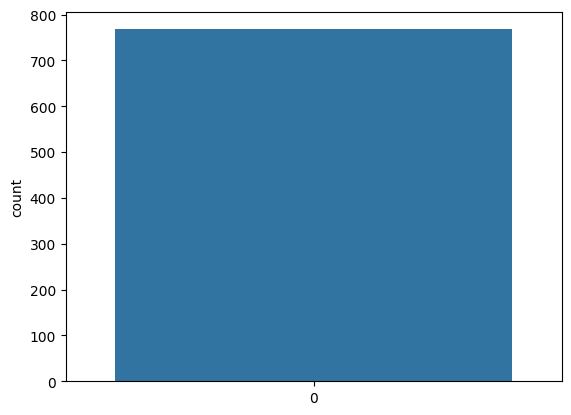

In [6]:
sns.countplot(data["Outcome"])

*The class distribution in the `Target` variable is ~65:35 which is not exactly imbalanced.*

### Feature Selection

<AxesSubplot: >

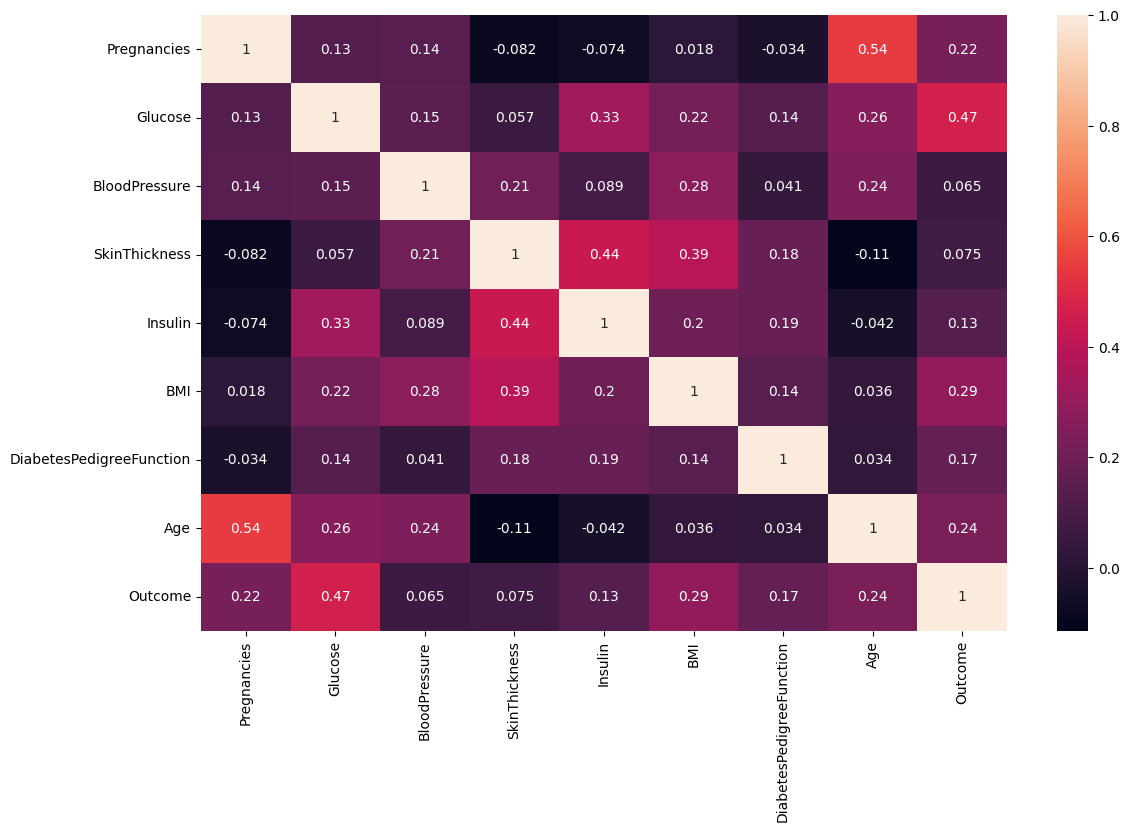

In [7]:
plt.figure(figsize=(13,8))
sns.heatmap(data.corr(), annot=True)

In [8]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


*As it can be seen that columns `Pregnancies` `Glucose` `BloodPressure` `SkinThickness` `Insulin` `BMI` has 0 values . Therefore these columns need to be imputed with their respective mean value.*

### Separating dependent and independent variables

In [9]:
# feature variables
x= data.iloc[:, :-1]

# target variable
y= data.iloc[:, -1]

### Splitting data into *train* and *test* 

In [10]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=1)

### Imputing with mean

In [11]:
from sklearn.impute import SimpleImputer
impute= SimpleImputer(missing_values= 0,  strategy='mean')
x_train= impute.fit_transform(x_train)
x_test= impute.fit_transform(x_test)                              

## Model Building

### Random Forest

In [12]:
rf_classifier= RandomForestClassifier()

rf_params= {"n_estimators" : [int(x) for x in np.linspace( start=100, stop=1000, num=10)],
            "criterion" : ["gini", "entropy"],
            "max_depth" : [int(x) for x in np.linspace(start= 100, stop=1000, num=10)],
            "min_samples_split": [1,3,6,7,8],
            "min_samples_leaf" : [3,4,6,7,9],
            "max_features" : ["auto", "sqrt", "log2"]}

rf_cv= KFold(n_splits=5)

rf_randomSearch= RandomizedSearchCV(estimator= rf_classifier,param_distributions=rf_params, n_iter=100,
                                    scoring="f1_macro", n_jobs=-1, cv= rf_cv, verbose=2, random_state=10)

rf_randomSearch.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=gini, max_depth=1000, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.4s
[CV] END criterion=gini, max_depth=1000, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.4s
[CV] END criterion=gini, max_depth=1000, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.8s
[CV] END criterion=gini, max_depth=1000, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=1000; total time=   3.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=1000; total time=   3.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=1000; total time=   3.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=1000; total time=   3.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=1000; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=800, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=600; total time=   2.6s
[CV] END criterion=entropy, max_depth=800, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=600; total time=   2.4s
[CV] END criterion=entropy, max_depth=800, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=600; total time=   2.4s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   1.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   1.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   1.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   1.9s
[CV] END criterion=entropy, max_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=300, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=300; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   3.9s
[CV] END criterion=gini, max_depth=700, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=7, n_estimators=500; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=7, n_estimators=500; total time=   2.1s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=7, n_estimators=500; total time=   2.3s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=7, n_estimators=500; total time=   2.2s
[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=9, min_samples_split=6, n_estimators=500; total time=   2.3s
[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=9, min_samples_split=6, n_estimators=500; total time=   2.2s
[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=9, min_samples_split=6, n_estimators=500; total time=   2.2s
[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=9, min_samples_split=6, n_estimators=500; total time=   2.2s
[CV] END criterion=g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=300; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=300; total time=   1.3s
[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=900; total time=   3.7s
[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=900; total time=   3.7s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=900; total time=   3.7s
[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=900; total time=   3.7s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=9, min_samples_split=8, n_estimators=300; total time=   1.2s
[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=900; total time=   3.8s
[CV] END criterion=e

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=600, max_features=log2, min_samples_leaf=9, min_samples_split=1, n_estimators=300; total time=   0.2s
[CV] END criterion=gini, max_depth=600, max_features=log2, min_samples_leaf=9, min_samples_split=1, n_estimators=300; total time=   0.2s
[CV] END criterion=gini, max_depth=800, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=900; total time=   3.1s
[CV] END criterion=gini, max_depth=800, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=900; total time=   3.1s
[CV] END criterion=gini, max_depth=800, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=900; total time=   3.1s
[CV] END criterion=gini, max_depth=800, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=900; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=800, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=900; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=   3.6s
[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=   3.7s
[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.2s
[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   1.6s
[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   1.6s
[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   1.6s
[CV] END criterion=gini, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.2s
[CV] END criterion=gini, max_depth=300, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   2.1s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   2.1s
[CV] END criterion=entropy, max_depth=600, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=800; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=600, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=800; total time=   3.4s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   1.8s
[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   1.7s
[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   1.1s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=700; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=700; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=700; total time=   2.7s
[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=700; total time=   2.3s
[CV] END criterion=entropy, max_depth=900, max_features=log2, min_samples_leaf=3, min_samples_split=1, n_estimators=200; total time=   0.1s
[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=700; total time=   2.4s
[CV] END criterion=entropy, max_depth=900, max_features=log2, min_samples_leaf=3, min_samples_split=1, n_estimators=200; total time=   0.1s
[CV] END criterion=entropy, max_depth=900, max_features=log2, min_samples_leaf=3, min_samples_split=1, n_estimators=200; total time=   0.1s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=7, n_estimators=700; total time=   2.7s
[CV] END criterion=e

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=700; total time=   2.4s
[CV] END criterion=entropy, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=700; total time=   2.5s
[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=600; total time=   2.1s
[CV] END criterion=entropy, max_depth=600, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=900; total time=   3.3s
[CV] END criterion=entropy, max_depth=600, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=900; total time=   3.3s
[CV] END criterion=entropy, max_depth=600, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=900; total time=   3.3s
[CV] END criterion=entropy, max_depth=600, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=900; total time=   3.3s
[CV] END criterion=e

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=600; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=600; total time=   2.4s
[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=600; total time=   2.4s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   0.8s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   0.8s
[CV] END criterion=entropy, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=600; total time=   2.7s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   0.9s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   0.9s
[CV] END criterion=gini, max

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_leaf=7, min_samples_split=1, n_estimators=400; total time=   0.3s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=1000; total time=   4.0s
[CV] END criterion=gini, max_depth=600, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=300; total time=   1.0s
[CV] END criterion=gini, max_depth=600, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=300; total time=   1.1s
[CV] END criterion=gini, max_depth=600, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=300; total time=   1.1s
[CV] END criterion=gini, max_depth=600, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=300; total time=   1.1s
[CV] END criterion=gini, max_depth=600, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=300; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s
[CV] END criterion=entropy, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s
[CV] END criterion=entropy, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=6, min_samples_split=3, n_estimators=700; total time=   2.6s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=6, min_samples_split=3, n_estimators=700; total time=   2.6s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=6, min_samples_split=3, n_estimators=700; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s
[CV] END criterion=entropy, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=300; total time=   1.3s
[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=1, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=1, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=1, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=600, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   2.3s
[CV] END criterion=entropy, max_depth=600, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   2.3s
[CV] END criterion=entropy, max_depth=600, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=600, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   2.3s
[CV] END criterion=entropy, max_depth=600, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=600; total time=   2.7s
[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=600; total time=   2.7s
[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=600; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=600; total time=   2.8s
[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=600; total time=   2.8s
[CV] END criterion=gini, max_depth=1000, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=400; total time=   1.8s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   3.3s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   3.2s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   3.2s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=500; total time=   0.4s
[CV] END criterion=gini, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=600, max_features=log2, min_samples_leaf=9, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=600, max_features=log2, min_samples_leaf=9, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=600, max_features=log2, min_samples_leaf=9, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=600, max_features=log2, min_samples_leaf=9, min_samples_split=8, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, max_depth=900, max_features=sqrt, min_samples_leaf=9, min_samples_split=7, n_estimators=100; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=900, max_features=sqrt, min_samples_leaf=9, min_samples_split=7, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   1.2s
[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   1.2s
[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=900, max_features=auto, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=900, max_features=auto, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=900, max_features=auto, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   1.3s
[CV] END criterion=gini, max_depth=900, max_features=auto, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   1.2s
[CV] END criterion=gini, max_depth=500, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=500, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=500, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.4s
[CV] END criterion=gini, max_depth=500, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.4s
[CV] END criterion=gini, max_depth=500, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=300; total time=   0.3s
[CV] END criterion=gini, max_depth=900,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=log2, min_samples_leaf=7, min_samples_split=8, n_estimators=200; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=9, min_samples_split=1, n_estimators=800; total time=   1.8s
[CV] END criterion=gini, max_depth=700, max_features=log2, min_samples_leaf=7, min_samples_split=8, n_estimators=200; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=9, min_samples_split=1, n_estimators=800; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=9, min_samples_split=1, n_estimators=800; total time=   1.6s
[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=9, min_samples_split=1, n_estimators=800; total time=   1.6s
[CV] END criterion=entropy, max_depth=600, max_features=sqrt, min_samples_leaf=9, min_samples_split=6, n_estimators=900; total time=   6.4s
[CV] END criterion=entropy, max_depth=600, max_features=sqrt, min_samples_leaf=9, min_samples_split=6, n_estimators=900; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=600, max_features=sqrt, min_samples_leaf=9, min_samples_split=6, n_estimators=900; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=600, max_features=sqrt, min_samples_leaf=9, min_samples_split=6, n_estimators=900; total time=   6.5s
[CV] END criterion=entropy, max_depth=600, max_features=sqrt, min_samples_leaf=9, min_samples_split=6, n_estimators=900; total time=   6.6s
[CV] END criterion=entropy, max_depth=900, max_features=auto, min_samples_leaf=9, min_samples_split=1, n_estimators=800; total time=   1.7s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=200; total time=   1.7s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=200; total time=   1.7s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=200; total time=   1.7s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=7, min_samples_split=7, n_estimators=200; total time=   1.8s
[CV] END criterion=gini, max_dep

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=200, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=200, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=1000; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=1, n_estimators=1000; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   7.0s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   7.1s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=1, n_estimators=1000; total time=   2.7s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=1, n_estimators=1000; total time=   2.6s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=1, n_estimators=1000; total time=   2.9s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   7.3s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=6, min_samples_split=8, n_estimators=700; total time=   7.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=1, n_estimators=1000; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   6.0s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   5.4s
[CV] END criterion=entropy, max_depth=900, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=   0.8s
[CV] END criterion=entropy, max_depth=200, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=900; total time=   9.2s
[CV] END criterion=entropy, max_depth=200, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=900; total time=   9.3s
[CV] END criterion=entropy, max_depth=200, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=900; total time=   9.2s
[CV] END criterion=entropy, max_depth=200, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=900; total time=   9.1s
[CV] END criterion=entropy, max_depth=200, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=900; total time=   8.7s
[CV] END criterion=ent

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=4, min_samples_split=1, n_estimators=900; total time=   1.3s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=4, min_samples_split=1, n_estimators=900; total time=   1.5s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=7, min_samples_split=8, n_estimators=600; total time=   4.4s
[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=4, min_samples_split=1, n_estimators=900; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=4, min_samples_split=1, n_estimators=900; total time=   1.2s
[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=4, min_samples_split=1, n_estimators=900; total time=   1.3s
[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   5.4s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   4.5s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   4.6s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   4.6s
[CV] END criterion=gini, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   5.6s
[CV] END criterion=gini, max_dept

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   2.6s
[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   2.6s
[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   2.6s
[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=4, min_samples_split=3, n_estimators=200; total time=   2.5s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   4.2s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=7, min_samples_split=8, n_estimators=400; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   3.6s
[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   3.6s
[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   3.7s
[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   3.6s
[CV] END criterion=entropy, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=300; total time=   3.8s
[CV] END criterion=gini, max_depth=800, max_features=log2, min_samples_leaf=9, min_samples_split=6, n_estimators=700; total time=   8.1s
[CV] END criterion=gini, max_depth=800, max_features=log2, min_samples_leaf=9, min_samples_split=6, n_estimators=700; total time=   8.1s
[CV] END criterion=gini, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   1.5s
[CV] END criterion=gini, max_depth=1000, max_features=log2, min_samples_leaf=6, min_samples_split=1, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=800, max_features=log2, min_samples_leaf=9, min_samples_split=6, n_estimators=700; total time=   9.3s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=   1.6s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=   1.5s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=   1.5s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=   1.5s
[CV] END criterion=entropy, max_depth=500, max_features=auto, min_samples_leaf=3, min_samples_split=7, n_estimators=100; total time=   1.5s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=100; total time=   1.3s
[CV] END criterion=gini, m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=100; total time=   1.4s
[CV] END criterion=gini, max_depth=100, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=100; total time=   1.5s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=500; total time=   7.8s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=1, n_estimators=400; total time=   1.4s
[CV] END criterion=entropy, max_depth=400, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=500; total time=   8.0s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=1, n_estimators=400; total time=   1.4s
[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=9, min_samples_split=1, n_estimators=400; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=500; total time=  16.4s
[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=500; total time=  16.4s
[CV] END criterion=entropy, max_depth=400, max_features=log2, min_samples_leaf=6, min_samples_split=6, n_estimators=500; total time=  17.1s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   5.9s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   6.0s
[CV] END criterion=gini, max_depth=200, max_features=log2, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   5.2s
[CV] END criterion=gini, max_depth=500, max_features=auto, min_samples_leaf=4, min_samples_split=3, n_estimators=1000; total time=  37.6s
[CV] END criterion=gini, max_de

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=600; total time=  23.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=400, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=600; total time=  23.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=  29.7s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=  29.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=  28.8s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=900; total time=  17.2s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=900; total time=  17.2s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=900; total time=  17.0s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=  20.0s
[CV] END criterion=entropy, max_depth=300, max_features=log2, min_samples_leaf=9, min_samples_split=7, n_estimators=1000; total time=  20.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=700; total time=  11.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=900; total time=  16.0s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=3, min_samples_split=3, n_estimators=900; total time=  16.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

[CV] END criterion=gini, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=700; total time=  12.5s
[CV] END criterion=gini, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=700; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=700; total time=  12.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=sqrt, min_samples_leaf=6, min_samples_split=6, n_estimators=700; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  13.3s
[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=500; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=500; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=500; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=500; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=200, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=500; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  17.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  16.5s
[CV] END criterion=gini, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  16.3s
[CV] END criterion=gini, max_depth=700, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=700; total time=  16.5s
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   4.1s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  16.6s
[CV] END criterion=entropy, max_depth=1000, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   4.1s
[CV] END criterion=gini, max_depth=300, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=700; total time=  15.5s
[CV] END criterion=entropy, max_d

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=900, max_features=sqrt, min_samples_leaf=7, min_samples_split=1, n_estimators=400; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=300; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=300; total time=   3.1s
[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=300; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=7, min_samples_split=6, n_estimators=800; total time=  10.1s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=7, min_samples_split=6, n_estimators=800; total time=  10.1s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=7, min_samples_split=6, n_estimators=800; total time=  10.1s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=7, min_samples_split=6, n_estimators=800; total time=  10.1s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_leaf=7, min_samples_split=6, n_estimators=800; total time=   9.9s
[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=300; total time=   2.6s
[CV] END criterion=gini, max_depth=400, max_features=auto, min_samples_leaf=7, min_samples_split=3, n_estimators=300; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
125 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [100, 200, 300, 400, 500,
                                                      600, 700, 800, 900,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [3, 4, 6, 7, 9],
                                        'min_samples_split': [1, 3, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=10, scoring='f1_macro', verbose=2)

In [14]:
print(rf_randomSearch.best_score_)
print(rf_randomSearch.best_params_)
print(rf_randomSearch.best_estimator_)

0.7477087918451817
{'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 300, 'criterion': 'gini'}
RandomForestClassifier(max_depth=300, max_features='auto', min_samples_leaf=3,
                       min_samples_split=6)


0.8116883116883117
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        99
           1       0.78      0.65      0.71        55

    accuracy                           0.81       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.81      0.81      0.81       154



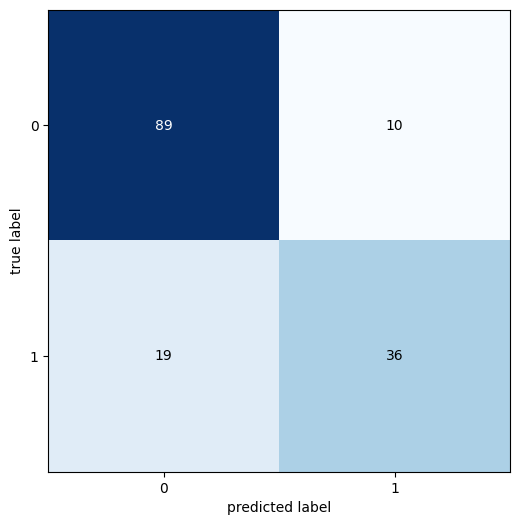

In [15]:
# best model
classifier_rf= rf_randomSearch.best_estimator_

rf_pred= classifier_rf.predict(x_test)

cm= confusion_matrix(y_test, rf_pred)
plot_confusion_matrix(cm, figsize=(6,6))

print(accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

### XgBoost

In [16]:
xgboost_classifier= xgboost.XGBClassifier()

xgboost_params= {"learning_rate": [0.1, 0.2, 0.25, 0.3, 0.35],
                 "max_depth": [3,4,5,7,8,9],
                 "min_child_weight": [2,4,5,6],
                 "gamma": [0.1, 0.2, 0.3, 0.4],
                 "colsample_bytree": [0.2,0.3, 0.4, 0.5]}

xgboost_cv= KFold(n_splits=5)

xgboost_search= RandomizedSearchCV(estimator= xgboost_classifier, param_distributions=xgboost_params, n_iter=100,
                                   scoring= "roc_auc", n_jobs=-1, cv=xgboost_cv, verbose=2, random_state=1)


xgboost_search.fit(x_train, y_train)

print(xgboost_search.best_score_)
print(xgboost_search.best_params_)
print(xgboost_search.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=2; total time=   0.0s
[CV] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=2; total time=   0.0s
[CV] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=2; total time=   0.0s
[CV] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.2, gamma=0.1, learning_rate=0.25, max_depth=3, min_child_weight=2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.

0.7857142857142857
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        99
           1       0.73      0.64      0.68        55

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154



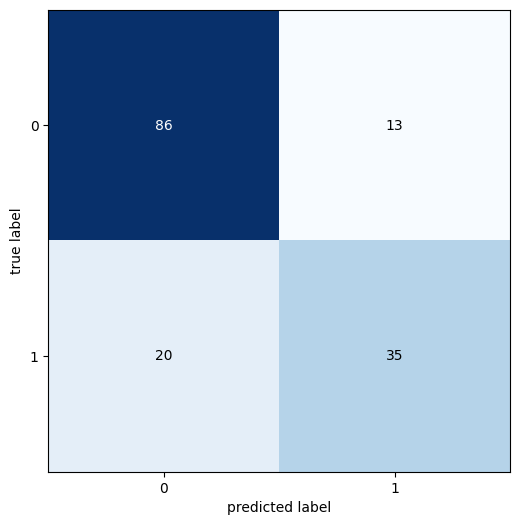

In [17]:
classifier_xgboost= xgboost_search.best_estimator_

xgboost_pred= classifier_xgboost.predict(x_test)

cm2= confusion_matrix(y_test, xgboost_pred)
plot_confusion_matrix(cm2, figsize=(6,6))

print(accuracy_score(y_test, xgboost_pred))
print(classification_report(y_test, xgboost_pred))

### Creating pickle file

In [47]:
pickle_out= open("classifier_diabetes.pkl", "wb")

pickle.dump(classifier_xgboost, pickle_out)
pickle_out.close()